# Reinforcement learning


**Attribution**: This notebook is a slightly modified version of the code from Chapter 18 of [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), by Aurélien Géron. (The source code for this book is available in [this Github repository](https://github.com/ageron/handson-ml2).)

# Setup


In [ ]:
import sys

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,194 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,537 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchp

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0" # because https://github.com/openai/gym/issues/3211

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.45.1
    Uninstalling wheel-0.45.1:
      Successfully uninstalled wheel-0.45.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip install -U tf-agents pyvirtualdisplay gym[atari,box2d]==0.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-agents to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708390 sha256=5e1622ec203886f96727242a9b592b748ddff9b211ed35480542fab1b3613c57
  Stored in directory: /root/.cache/pip/wheels/42/e8/e8/6dfbc92a1dcd76c1a5e2bb982750fd6b7e792239f46039e6b1
  Created wheel for box2d-p

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')


In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")



In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [ ]:
import gym

Let's list all the available environments:

In [ ]:
gym.envs.registry.all()

ValuesView(├──ALE
│   ├──ALE/Tetris: [ v5 ]
│   └──ALE/Tetris-ram: [ v5 ]
│
├──Adventure: [ v0, v4 ]
├──AdventureDeterministic: [ v0, v4 ]
├──AdventureNoFrameskip: [ v0, v4 ]
├──Adventure-ram: [ v0, v4 ]
├──Adventure-ramDeterministic: [ v0, v4 ]
├──Adventure-ramNoFrameskip: [ v0, v4 ]
├──AirRaid: [ v0, v4 ]
├──AirRaidDeterministic: [ v0, v4 ]
├──AirRaidNoFrameskip: [ v0, v4 ]
├──AirRaid-ram: [ v0, v4 ]
├──AirRaid-ramDeterministic: [ v0, v4 ]
├──AirRaid-ramNoFrameskip: [ v0, v4 ]
├──Alien: [ v0, v4 ]
├──AlienDeterministic: [ v0, v4 ]
├──AlienNoFrameskip: [ v0, v4 ]
├──Alien-ram: [ v0, v4 ]
├──Alien-ramDeterministic: [ v0, v4 ]
├──Alien-ramNoFrameskip: [ v0, v4 ]
├──Amidar: [ v0, v4 ]
├──AmidarDeterministic: [ v0, v4 ]
├──AmidarNoFrameskip: [ v0, v4 ]
├──Amidar-ram: [ v0, v4 ]
├──Amidar-ramDeterministic: [ v0, v4 ]
├──Amidar-ramNoFrameskip: [ v0, v4 ]
├──Assault: [ v0, v4 ]
├──AssaultDeterministic: [ v0, v4 ]
├──AssaultNoFrameskip: [ v0, v4 ]
├──Assault-ram: [ v0, v4 ]
├──Assault-ramDete

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [ ]:
env = gym.make('CartPole-v1')

You can learn more about the environment from the description in the [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [ ]:
env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 is vertical, > 0 means leaning to the right, < 0 means leaning to the left), and the angular velocity.

In [ ]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

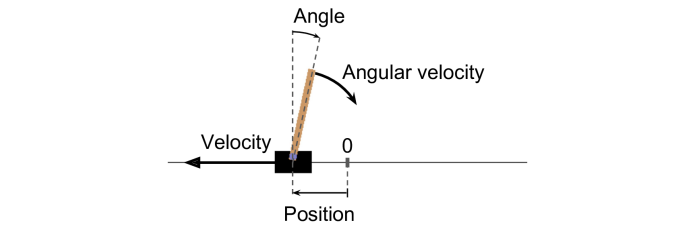

An environment can be visualized by calling its `render()` method.

**Warning**: some environments (including the Cart-Pole) require access to a display. If the notebook is running on a headless server (ie. without a screen) it will raise an error when you try to `render()` it. One way to avoid this is to set up a "virtual display".

In [ ]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
env.render()

True

In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [ ]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

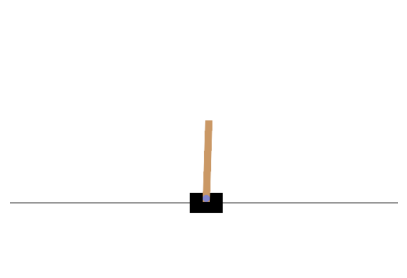

In [ ]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [ ]:
env.action_space

Discrete(2)

There are two possible actions: accelerate towards the left or towards the right.

Let's remind ourselves of the last observation:

In [ ]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

Note that:

* the cart was moving toward the left (`obs[1] < 0`) but is still near the center
* the pole was tilted toward the right (`obs[2] > 0`)
* the angular velocity of the pole indicates that it will tilt toward the left (`obs[3] < 0`)

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [ ]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is more  negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

Saving figure cart_pole_plot


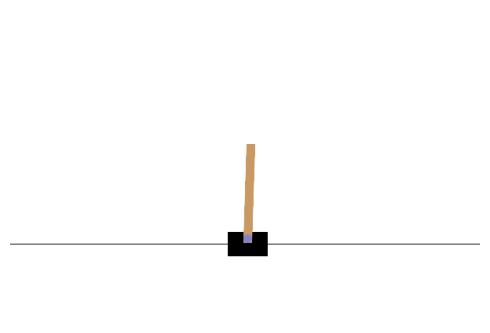

In [ ]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [ ]:
reward

1.0

In Cartpole, the agent earns a reward of +1 for every timestep in an episode, but an episode ends if

* the pole is more than 12 degrees from vertical, or
* the cart moves more than 2.4 units from the center (the cart can't move off the display!)

When the game is over, the environment returns `done=True`:

In [ ]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [ ]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [ ]:
if done:
    obs = env.reset()

Let's see what happens if we keep accelerating toward the right:

In [ ]:
frames = []
action = 1
done = False
env.reset()
while not done:
  img = env.render(mode="rgb_array")
  frames.append(img)
  obs, reward, done, info = env.step(action)
  print(obs, reward, done)

[-0.03963102  0.24230015  0.0266861  -0.25572422] 1.0 False
[-0.03478502  0.43703112  0.02157161 -0.5398719 ] 1.0 False
[-0.02604439  0.6318433   0.01077418 -0.8256806 ] 1.0 False
[-0.01340753  0.82681626 -0.00573944 -1.1149555 ] 1.0 False
[ 0.0031288   1.0220131  -0.02803855 -1.4094334 ] 1.0 False
[ 0.02356906  1.2174714  -0.05622721 -1.7107477 ] 1.0 False
[ 0.04791848  1.4131923  -0.09044217 -2.0203874 ] 1.0 False
[ 0.07618233  1.6091276  -0.13084991 -2.3396428 ] 1.0 False
[ 0.10836489  1.8051639  -0.17764278 -2.6695435 ] 1.0 False
[ 0.14446816  2.0011039  -0.23103364 -3.010781  ] 1.0 True


We can look at an animation of the episode:



In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
plot_animation(frames)

Now how can we make the pole remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [ ]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.212, 9.032998173364147, 24.0, 72.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the pole up for only 68 steps. This environment is considered solved when the agent keeps the pole up for 200 steps (it is also "done" if it reaches 200 steps).

Let's visualize one episode:

In [ ]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [ ]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Input(shape=[n_inputs]),
    keras.layers.Dense(5, activation="elu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

Our agent is going to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well.

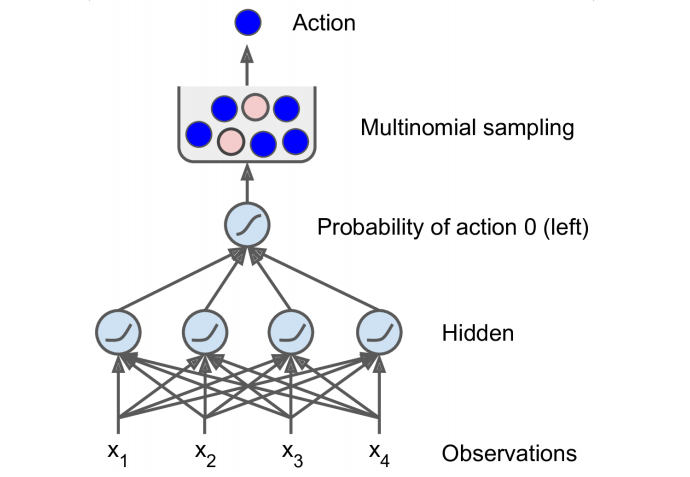

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

<ipython-input-33-6c331f60581f>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

Random play is not very good!



First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We will "train" the model using supervised learning, by specifying the target variable according to our basic policy.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [ ]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

losses = []
for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
        losses.append(loss)
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.090

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-33-6c331f60581f>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

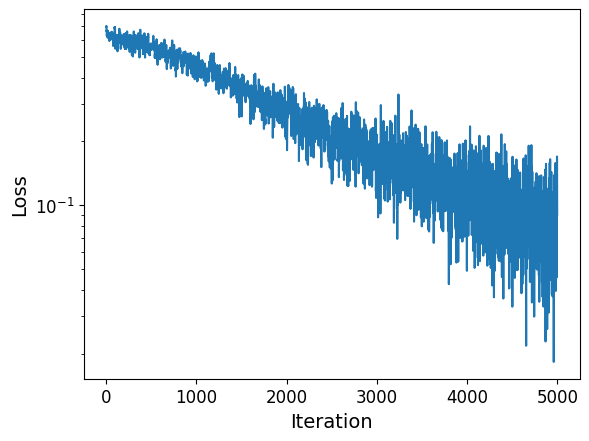

In [ ]:
plt.semilogy(losses);
plt.xlabel("Iteration");
plt.ylabel("Loss");

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network, we had to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad?

The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes (that earned more reward) slightly more likely, while actions in bad episodes (that earned less reward) are made slightly less likely. First we play, then we go back and think about what we did.

Of course, a good action may be followed by several bad actions that cause the pole to fall quickly, resulting in the good action getting a low return. However, if we play the game enough times, on average good actions will get a higher return than bad ones.

The policy gradient algorithm we will use is called REINFORCE, and it works like this:

1. First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely - but don’t apply these gradients yet.
2. Once you have run several episodes, compute each action’s discounted rewards.
3. If an action has positive discounted rewards, it means that the action was probably good, and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action’s discounted rewards are negative, it means the action was probably bad, and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s discounted rewards.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a gradient descent step.

First, let's set up a network and an environment so we can test things out.

In [ ]:
n_iterations = 1   # for now!
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input(shape=[4]),
    keras.layers.Dense(5, activation="elu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
env = gym.make("CartPole-v1")
env.seed(42);

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Here,

* If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`).
* Then `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Here's one iteration of this function:

In [ ]:
obs = env.reset()

In [ ]:
obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

And here's how it works - for 2 episodes.

In [ ]:
all_rewards, all_grads = play_multiple_episodes(env, 2, 200, model, loss_fn)

In [ ]:
np.sum(all_rewards[0])

12.0

In [ ]:
np.sum(all_rewards[1])

14.0

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them.



So let's create a couple of functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

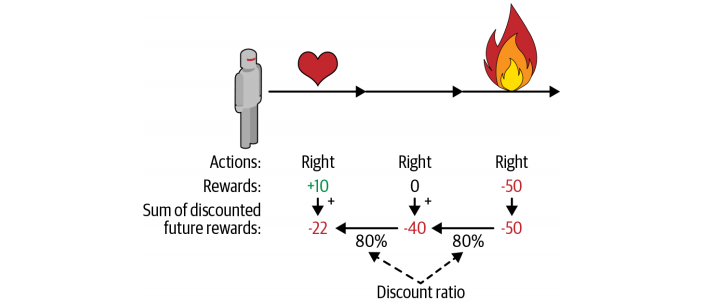

In [ ]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

Here's what it looks like for the rewards from the previous step:

In [ ]:
discount_rewards(all_rewards[0], discount_rate=0.95)

array([9.19279825, 8.62399815, 8.02526122, 7.39501181, 6.73159137,
       6.03325408, 5.29816219, 4.52438125, 3.709875  , 2.8525    ,
       1.95      , 1.        ])

In [ ]:
discount_rewards(all_rewards[1], discount_rate=0.95)

array([10.24650042,  9.73315833,  9.19279825,  8.62399815,  8.02526122,
        7.39501181,  6.73159137,  6.03325408,  5.29816219,  4.52438125,
        3.709875  ,  2.8525    ,  1.95      ,  1.        ])

This tells us - the actions we took early in the game were OK, but the actions later in the game, which led to the pole falling, were not as good.

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Let's also try this for the rewards of our previous "step":



In [ ]:
discount_and_normalize_rewards(all_rewards, discount_rate=0.95)

[array([ 1.23573509,  1.02890892,  0.81119717,  0.5820269 ,  0.34079504,
         0.08686676, -0.18042616, -0.46178713, -0.75795657, -1.06971388,
        -1.39787947, -1.74331693]),
 array([ 1.61888057,  1.43221995,  1.23573509,  1.02890892,  0.81119717,
         0.5820269 ,  0.34079504,  0.08686676, -0.18042616, -0.46178713,
        -0.75795657, -1.06971388, -1.39787947, -1.74331693])]

Actions from later in the game have negative discounted rewards.

Now, an iteration of our model look like this:


In [ ]:
rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    rewards.append(total_rewards / n_episodes_per_update)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))


Iteration: 0, mean rewards: 16.9

Let’s walk through this code:

* At each training iteration, this loop calls the play_multiple_episodes() function, which plays the game `n_episodes_per_update` times and returns all the rewards and gradients for every episode and step.
* Then we call the `discount_and_normalize_rewards()` to compute each action’s
normalized discounted reward (which in the code we call the `final_reward)`. This provides a measure of how good or bad each action actually was, in hindsight.
* Next, we go through each trainable variable, and for each of them we compute
the weighted mean of the gradients for that variable over all episodes and all
steps, weighted by the `final_reward`.
* Finally, we apply these mean gradients using the optimizer: the model’s trainable variables will be tweaked, and hopefully the policy will be a bit better.

OK, now that everything is set up, let's try it out with many iterations!

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input(shape=[4]),
    keras.layers.Dense(5, activation="elu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
env = gym.make("CartPole-v1")
env.seed(42);

rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    rewards.append(total_rewards / n_episodes_per_update)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 185.0

Saving figure pg_rewards_plot


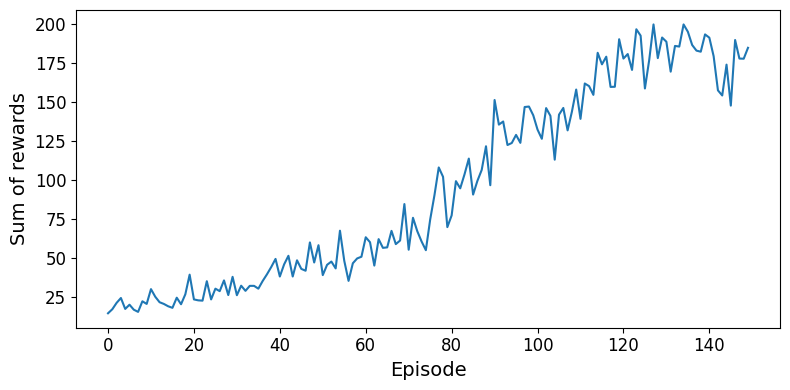

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("pg_rewards_plot")
plt.show()

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-33-6c331f60581f>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In contrast to the policy-based method above, which tries to directly adjust the policy of the agent, value-based methods try to learn the value function - the expected total reward associated with each state or each state-action pair.

Then, the implicit policy is just to choose the action that will maximize the expected value.

# Deep Q-Network

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy is just choosing the action that has the highest Q-Value (i.e., the greedy policy).

$$Q(s,a) \rightarrow r + \gamma \max_{a'} Q(s', a')$$

For a game with a small state space, we can keep track of the estimated $Q(s,a)$ for each state-action pair directly, in a Q table. But for a more complicated game, where the state space is very large, it is not feasible to do so.

Instead, we can train a model (parameterized by $W$) to approximate the Q value of any state action pair: $Q_W(s,a)$. When the model is a deep neural network, we call it Deep Q-Learning.



How will we train the model - what is the target variable and the loss function?

From some state $s$,

* We'll execute the DQN on the next state $s'$ for all possible actions $a'$, and get an approximate future Q value for each possible action.
* We'll pick the highest one and discount it, to get an estimate of the cumulative future discounted rewards.
* Add the future discounted value and the current reward $r$. This is the *target* Q value for this state-action pair.

$$Q_t(s,a)= r + \gamma \max_{a'} Q_W(s', a')$$

* Then we can train the model, using squared error loss of the predicted value vs. $Q_t(s,a)$.

Let's build a DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome).

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

Note that now we have *two* output units.

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will start training with a large value of `epsilon`, so we explore the state space at the beginning. Then, we will gradually reduce `epsilon` so that we start to focus mainly on the optimal actions.

Instead of training the DQN based only on the latest experiences, we will store all experiences in a replay buffer (or replay memory), and we will sample a random training batch from it at each training iteration. This helps reduce the correlations between the experiences in a training batch, which improves the training performance.

We will therefore need a replay memory. It will contain the agent's experiences, in the form of tuples: `(state, action, reward, next_state, done)`. We can use the `deque` class for that:

In [ ]:
from collections import deque

replay_memory = deque(maxlen=2000)

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `states, actions, rewards, next_states, dones`.

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:


In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

What happens in a training step?

* It starts by sampling a batch of experiences, then it uses the DQN to predict the Q-Value for each possible action in each experience’s next state. Since we assume that the agent will be playing optimally, we only keep the maximum Q-Value for each next state.
* Then, we compute the target Q-Value (${y}$) for each experience’s state-action
pair: we get the immediate rewards, plus the discounted max $Q(s',a')$ for the next state (if we're not `done`!)
* Now we want to use the DQN to compute the predicted Q-Value ($\hat{y}$) for each experienced
state-action pair. However, the DQN will also output the Q-Values for the other possible actions, not just for the action that was actually chosen by the agent. So we need to mask out all the Q-Values we do not need:
  * The `tf.one_hot()` function makes it easy to convert an array of action indices into a mask.
  * For example, if the first three experiences contain actions 1, 1, 0, respectively, then the mask will start with `[[0, 1], [0, 1], [1, 0],...]`.
  * We then multiply the DQN’s output with this mask, and this will zero out all the Q-Values we do not want.
  * Finally,  sum over axis 1 to get rid of all the zeros, keeping only the Q values of the experienced state-action pairs. This gives us `Q_values`, which has one predicted Q-Value for each experience in the batch
* Now we have $y$ and $\hat{y}$, so we can compute the loss.
* Finally, we perform a gradient descent step to minimize the loss with respect to the model parameters.


And now, let's train the model!

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

You might wonder why we didn’t plot the loss. It turns out that loss is a poor indicator of the model’s performance. The loss might go down, yet the agent might perform worse (e.g., this can happen when the agent gets stuck in one small region of the environment, and the DQN starts overfitting this region). Conversely, the loss could go up, yet the agent might perform better (e.g., if the DQN was underestimating the QValues, and it starts correctly increasing its predictions, the agent will likely perform better, getting more rewards, but the loss might increase because the DQN also sets the targets, which will be larger too).

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

Not bad at all! 😀